In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely import Point 


DATA_DIR = Path('../backend/api/data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'
INFOBUSES = RAW_DATA / 'buses'

df = dd.read_csv(INFOBUSES / '2018-05-01.gps.csv', parse_dates=['datetime'], sep=';') #meta = (str, str, str, float, float))
df['id'] = df['patente'] + '---' + df['recorrido']
df = df.drop(columns=['nose', 'nose1', 'nose2', 'nose3','nose4']).replace(' ', np.nan).dropna().reset_index(drop=True)
# df.compute()
df

,patente,recorrido,datetime,lat,lon,id
npartitions=10,,,,,,
,string,string,datetime64[ns],float64,float64,string
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


# Patentes

In [24]:
frecuencias = df['patente'].value_counts().compute()

In [14]:
sorted = frecuencias.sort_values()
print('existe un total de {count} patentes, cuyas frecuencias van desde los {min} a los {max} registros por patente'.format(count=len(sorted), min=sorted.iloc[0], max=sorted.iloc[-1]))
sorted

existe un total de 6527 patentes, cuyas frecuencias van desde los 2 a los 2880 registros por patente


patente
BJFW-32       2
CJRJ-37       2
BJFD-74       4
ZU-5659       4
CJRV-32       4
           ... 
CJRS-32    2880
ZN-4403    2880
FLXC-28    2880
CRBJ-37    2880
FLXP-31    2880
Name: count, Length: 6527, dtype: int64

<Axes: xlabel='Patentes ordenadas por frecuencia', ylabel='Frecuencias'>

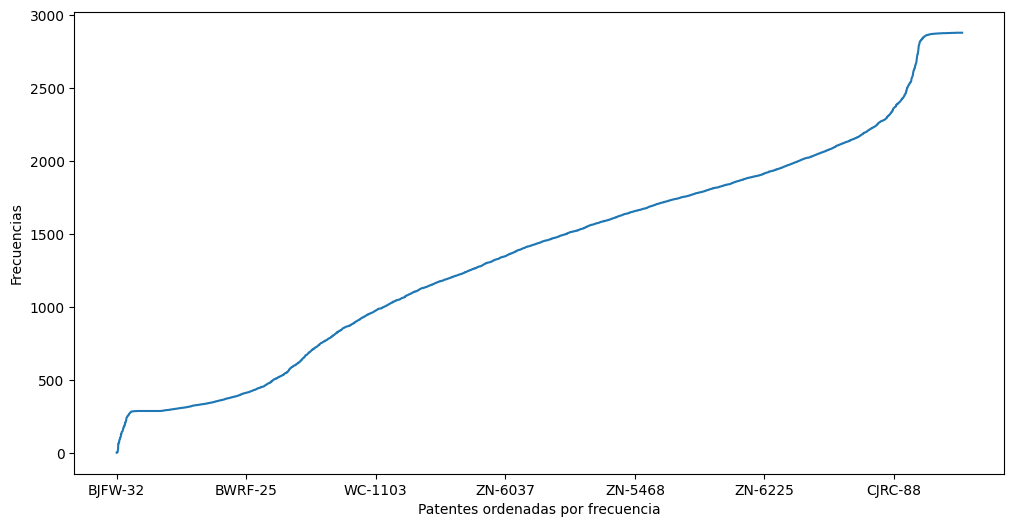

In [16]:
sorted.plot(xlabel = 'Patentes ordenadas por frecuencia', ylabel='Frecuencias', figsize=(12, 6))

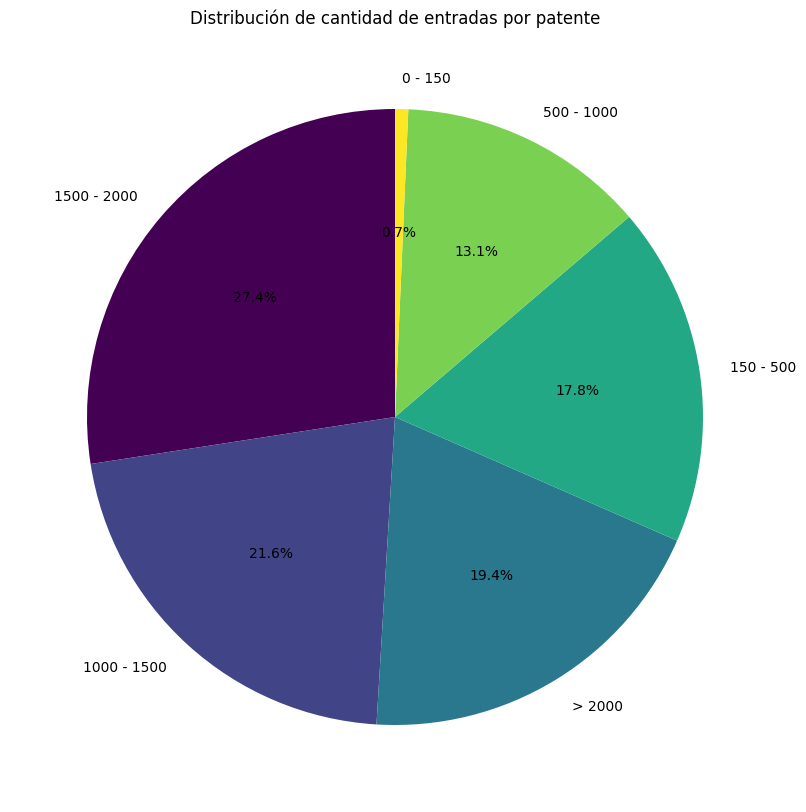

In [25]:
bins = [0, 150, 500, 1000, 1500, 2000, 2880]
labels = ['0 - 150',  '150 - 500',  '500 - 1000',  '1000 - 1500', '1500 - 2000', '> 2000']

agrupadas = pd.cut(frecuencias, bins=bins, labels=labels, include_lowest=True)
rango_counts = agrupadas.value_counts()

plt.figure(figsize=(10, 10))
rango_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribución de cantidad de entradas por patente')
plt.ylabel('')  # Quitar la etiqueta del eje y
plt.show()


# Nombre de los recorridos

In [2]:
recorridos = df['recorrido'].unique()

# .apply(lambda x: x[-1], meta=('recorrido', 'str')).compute().value_counts()

In [3]:
servicios = recorridos.apply(lambda x: x.split(' ')[0], meta=('recorrido', 'str')).value_counts().compute()
print('todos los servicios')
servicios

todos los servicios


recorrido
B06      2
B09      2
B25      4
B30      2
B51      4
        ..
T423     2
T428    12
T507     4
T515     2
T539     4
Name: count, Length: 311, dtype: int64

<Axes: xlabel='Cantidad de variaciones', ylabel='Cantidad de recorridos con esa variación'>

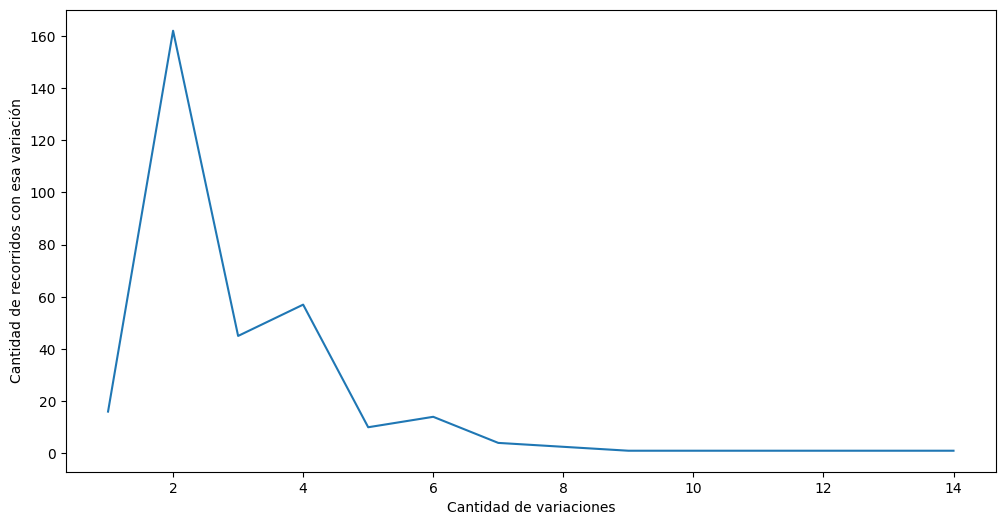

In [9]:
servicios.sort_values().value_counts().sort_index().plot(xlabel='Cantidad de variaciones', ylabel='Cantidad de recorridos con esa variación', figsize=(12,6))

In [3]:
sentidos = recorridos.apply(lambda x: x[-1], meta=('recorrido', 'str')).value_counts().compute()
print('sentidos del recorrido')
sentidos

sentidos del recorrido


recorrido
R    446
I    454
Name: count, dtype: int64

In [6]:
sentidos.index = ['Retorno', 'Ida']

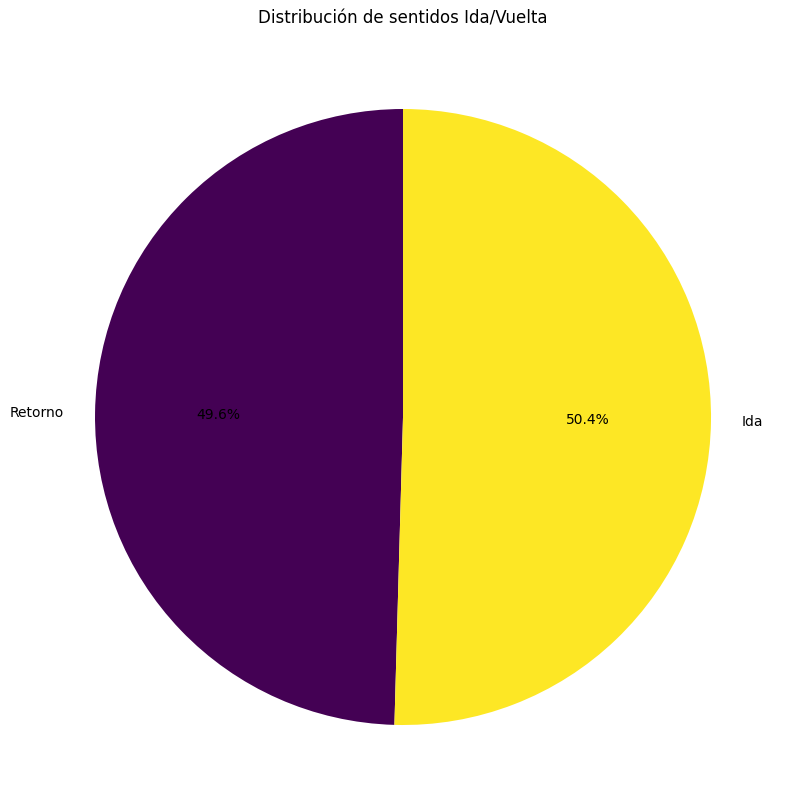

In [9]:
plt.figure(figsize=(10, 10))
sentidos.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribución de sentidos Ida/Vuelta')
plt.ylabel('')  # Quitar la etiqueta del eje y
plt.show()


In [13]:
variaciones = recorridos.apply(lambda x: x.split(' ')[-1][:-1], meta=('recorrido', 'str')).value_counts().compute()
print('posibles variaciones')
variaciones

posibles variaciones


recorrido
00    693
02     17
01     13
07     16
09      3
10      3
04      4
05      6
06     69
03     72
08      4
Name: count, dtype: int64

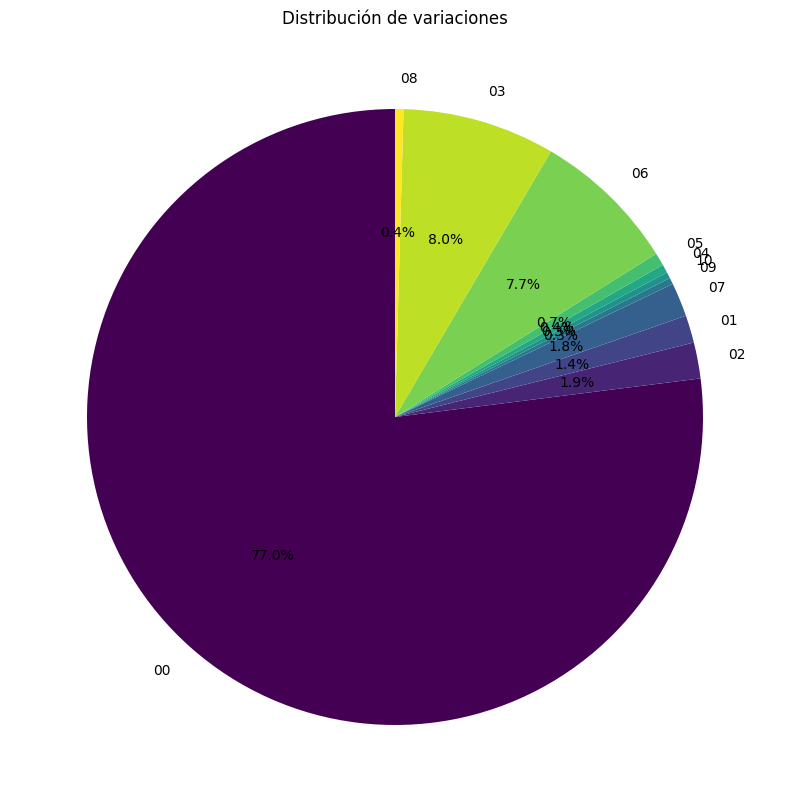

In [15]:
plt.figure(figsize=(10, 10))
variaciones.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribución de variaciones')
plt.ylabel('')  # Quitar la etiqueta del eje y
plt.show()

# Análisis de los datos

## Cuantas entradas hay por viaje?

In [2]:
points_per_ride = df['id'].value_counts().compute()

In [3]:
points_per_ride.sort_values()
points_per_ride.to_csv(PROCESSED_DATA / 'puntos_por_viaje.csv')

<Axes: title={'center': 'Cantidad de puntos por viaje'}, xlabel='Id', ylabel='Frecuencia'>

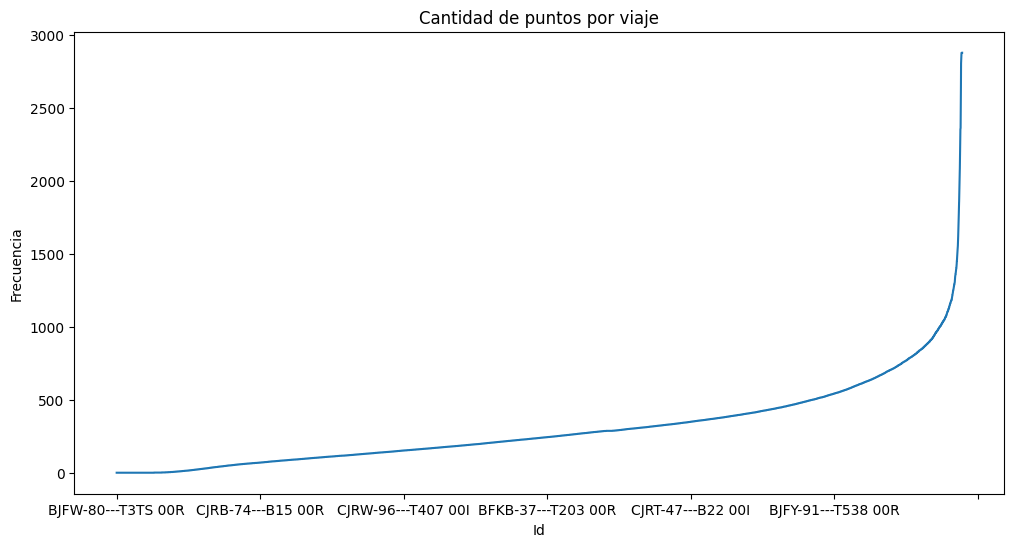

In [4]:
points_per_ride.sort_values().plot(title='Cantidad de puntos por viaje', figsize=(12, 6), ylabel= 'Frecuencia', xlabel='Id')

29451 29451


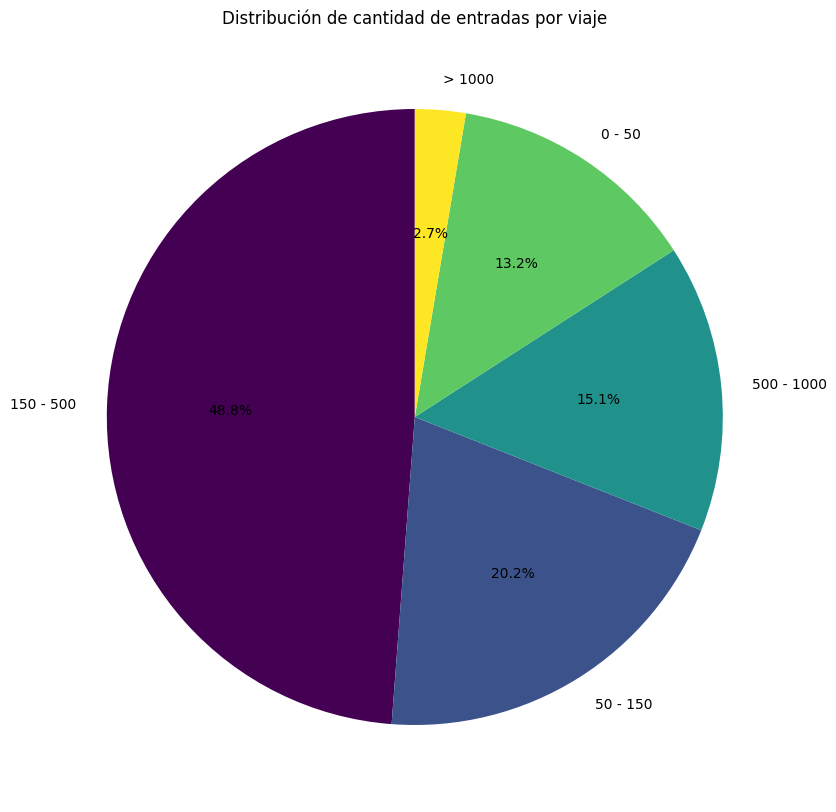

In [6]:
bins = [0, 50, 150, 500, 1000, 2880]
labels = ['0 - 50' , '50 - 150',  '150 - 500',  '500 - 1000',  '> 1000']

agrupadas = pd.cut(points_per_ride, bins=bins, labels=labels, include_lowest=True)
rango_counts = agrupadas.value_counts()

print(len(points_per_ride), rango_counts.agg('sum'))

plt.figure(figsize=(10, 10))
rango_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribución de cantidad de entradas por viaje')
plt.ylabel('')  # Quitar la etiqueta del eje y
plt.show()


<Axes: title={'center': 'Distribución de cantidad de entradas por viaje'}, xlabel='count'>

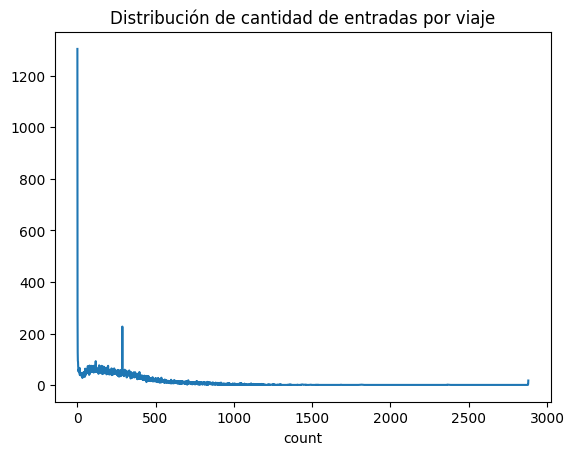

In [9]:
count_distribution = points_per_ride.value_counts()
count_distribution.sort_index().plot(title='Distribución de cantidad de entradas por viaje')

In [10]:
print("Hay {} viajes con {} entrada".format(count_distribution[count_distribution.idxmax()], count_distribution.idxmax()))
# print("Hay {} viajes con {} entrada".format(count_distribution[count_distribution.idxmin()], count_distribution.idmin()))

Hay 1303 viajes con 1 entrada


## Utilizando RDP
El algoritmo de *Ramer–Douglas–Peucker* (RDP): es un algoritmo de reducción de puntos de una línea que va descartando iterativamente los puntos que generen la menor distancia entre la curva original y la curva simplificada 

In [10]:
import rdp
from shapely import Point

# ZN-6498---T108 00R -> viaje arbitrario con 179 puntos
viaje = df[df['id'] == 'ZN-6498---T108 00R']
puntos_originales = viaje.apply(lambda row: Point(row['lon'], row['lat']), axis=1).compute()
print(puntos_originales)

/home/flac/Documents/BusY/venv-notebooks/lib/python3.11/site-packages/dask_expr/_collection.py:3037: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


0     POINT (-70.55772418 -33.51791023)
1     POINT (-70.55726684 -33.52002626)
2     POINT (-70.55684177 -33.52214189)
3     POINT (-70.55962166 -33.52225121)
4     POINT (-70.56083855 -33.52226293)
                    ...                
76    POINT (-70.78743772 -33.54313294)
77    POINT (-70.78743772 -33.54313294)
78    POINT (-70.78777964 -33.54300175)
79    POINT (-70.78834076 -33.54253373)
80    POINT (-70.78664662 -33.54132275)
Length: 179, dtype: object


(-33.54330966, -33.48356964)

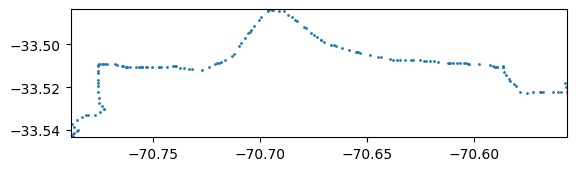

In [11]:
gdf_orig = gpd.GeoDataFrame(geometry=puntos_originales)
# print(gdf_orig)
ax = gdf_orig.plot(markersize=1)
minx, miny, maxx, maxy = gdf_orig.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [12]:
def list_to_geometry(L):
    for i in range(len(L)):
        L[i] = Point(L[i][0], L[i][1])
    return L


In [13]:
ALPHA = 0.0001

lista_de_listas = list(puntos_originales.apply(lambda p: [p.x, p.y]))
new_lista = rdp.rdp(lista_de_listas, ALPHA)
print("pasamos de {} a {} puntos con un alpha={}".format(len(lista_de_listas), len(new_lista), ALPHA))
gdf_new = gpd.GeoDataFrame(geometry=list_to_geometry(new_lista))
# ax = gdf_new.plot(markersize=1)
# minx, miny, maxx, maxy = gdf_orig.total_bounds
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

pasamos de 179 a 61 puntos con un alpha=0.0001


<Axes: >

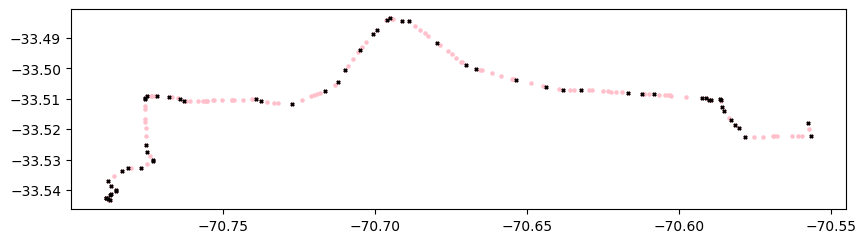

In [14]:
ax = gdf_orig.plot(markersize=5, color='pink', figsize=(10,10))
gdf_new.plot(ax=ax, marker="x", markersize=5, color='black')

[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]


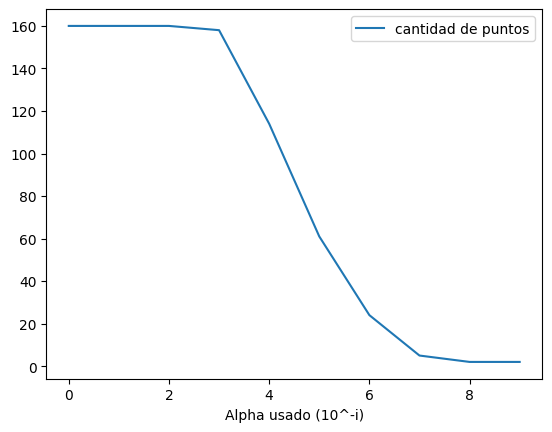

In [8]:
# como varian los puntos según alpha?
alphas = np.power([0.1 for _ in range(10)], range(10))
print(alphas)
puntos_count = [len(rdp.rdp(lista_de_listas, alpha)) for alpha in alphas]
ax = pd.DataFrame(data={'alphas': range(10).__reversed__(), 'cantidad de puntos': puntos_count}).set_index('alphas').plot(xlabel='Alpha usado (10^-i)')

In [9]:
puntos_count

[2, 2, 5, 24, 61, 114, 158, 160, 160, 160]

## Cuál es la distribución temporal?

In [2]:
times = pd.to_datetime(df['datetime'])

In [40]:
time_df = pd.DataFrame()
time_df['datetime'] = times
time_df

,datetime
0,2018-04-30 23:59:16
1,2018-04-30 23:59:46
2,2018-04-30 23:59:17
3,2018-04-30 23:59:47
4,2018-04-30 23:59:07
...,...
9003257,2018-05-01 23:58:39
9003258,2018-05-01 23:58:11
9003259,2018-05-01 23:58:41
9003260,2018-05-01 23:58:25


In [47]:
counts = time_df.set_index('datetime')
counts['count'] = 1
resample = counts.resample('15min').count()
resample

,count
datetime,
2018-04-30 23:00:00,1
2018-04-30 23:15:00,0
2018-04-30 23:30:00,4
2018-04-30 23:45:00,6994
2018-05-01 00:00:00,90640
...,...
2018-05-01 22:45:00,98789
2018-05-01 23:00:00,96330
2018-05-01 23:15:00,92396


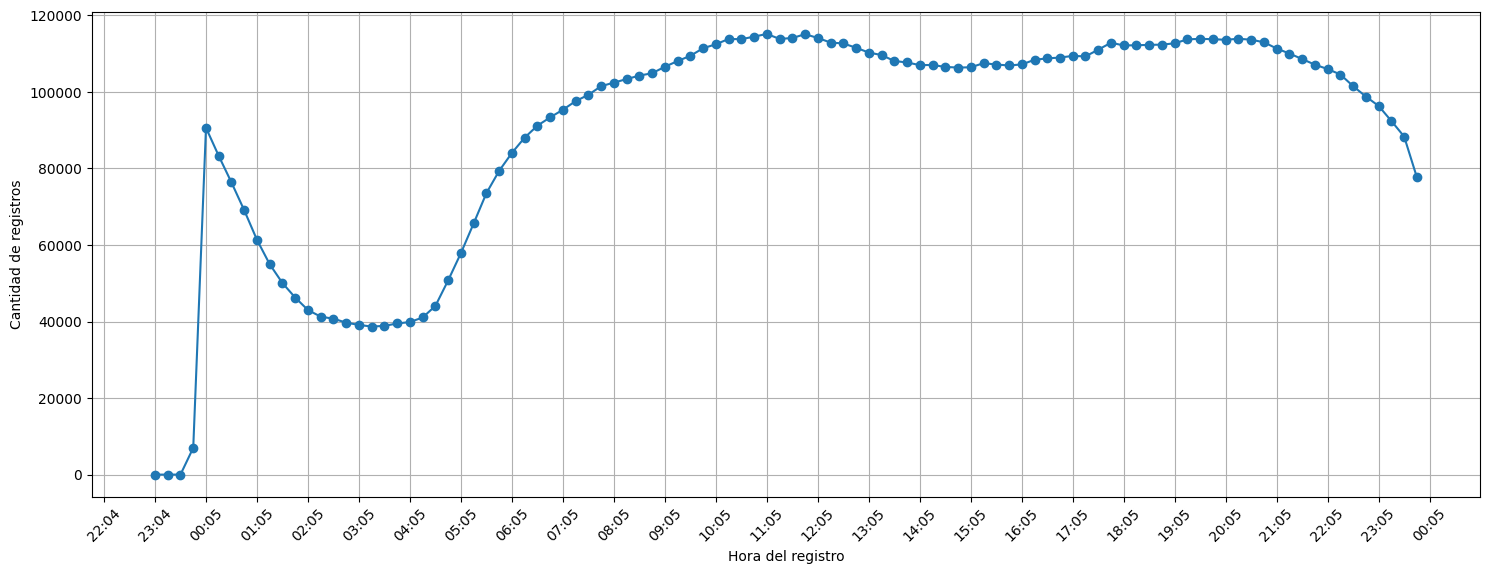

In [57]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.plot(resample.index, resample['count'], marker='o', linestyle='-')
plt.xlabel('Hora del registro')
plt.ylabel('Cantidad de registros')
# plt.title('')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Formatear el eje X para mostrar cada hora y con etiquetas completas
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))

plt.show()

In [19]:
# rides per service
services = df.groupby('recorrido')
points_per_service = services.apply(lambda g: len(g)) #.compute()
rides_per_service = services.apply(lambda g: len(g['patente'].value_counts())).compute()

/tmp/ipykernel_4092/3881752121.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  points_per_service = services.apply(lambda g: len(g)) #.compute()
/tmp/ipykernel_4092/3881752121.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  rides_per_service = services.apply(lambda g: len(g['patente'].value_counts())).compute()


<Axes: title={'center': 'Cantidad de viajes por recorrido'}, xlabel='recorrido'>

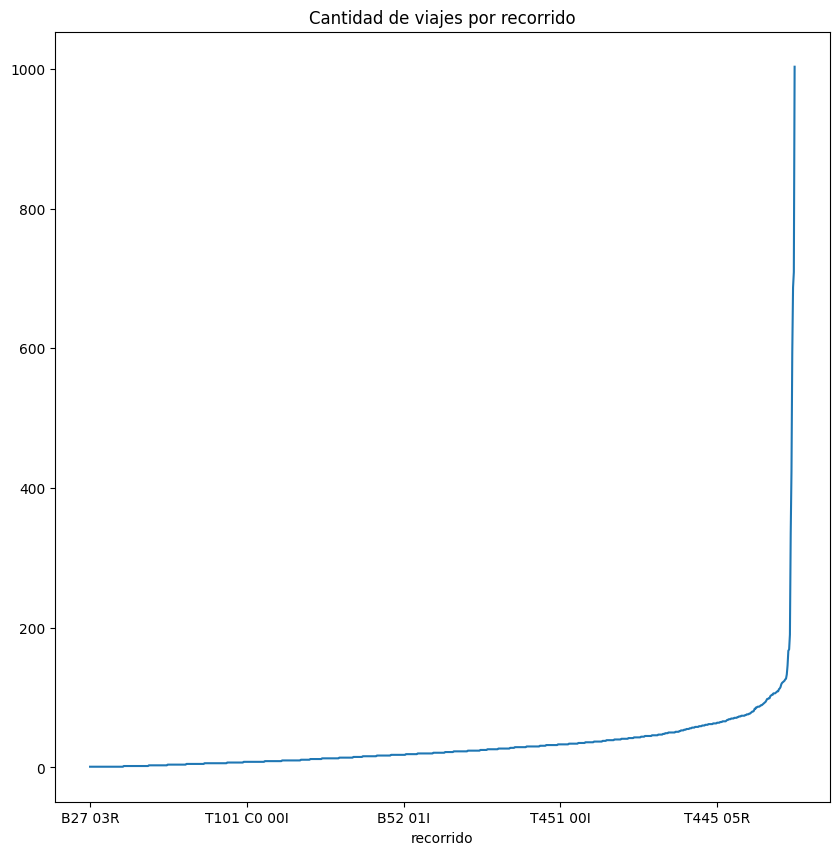

In [20]:
rides_per_service.sort_values().plot(title='Cantidad de viajes por recorrido', figsize=(10,10))

In [21]:
print("El recorrido más común es {} con {} viajes distintos".format(rides_per_service.idxmax(), rides_per_service[rides_per_service.idxmax()]))

El recorrido más común es T2TS 00I con 1003 viajes distintos


## Cuanto pasa entre registros?
Se agruparán los registros según recorrido-patente para estimar cuanto pasa entre registro y registro.

In [108]:
velocidades = df.drop(columns=['patente', 'recorrido', 'lat', 'lon'])
velocidades = velocidades.get_partition(0)
def calcularDiffTiempo(grupo):
    sorted = grupo.sort_values(by='datetime')
    sorted['diffs'] = sorted['datetime'].diff().fillna('0')
    sorted['diffs'] = sorted['diffs'].apply(lambda d: d.total_seconds()/60)
    return sorted.drop(columns=['datetime', 'id'])

velocidades = velocidades.groupby('id').apply(calcularDiffTiempo, meta={'diffs': 'float'}).reset_index(drop=False).compute() 
#.apply(calcularDiffTiempo, include_groups=False, meta={'x': 'float'}).compute()
counts = velocidades['diffs'].value_counts()

diffs
0.500000      7510199
5.000000       948429
0.516667       164417
0.483333       148612
5.016667        32558
               ...   
223.616667          1
159.400000          1
151.533333          1
164.933333          1
504.650000          1
Name: count, Length: 14265, dtype: int64

<Axes: xlabel='diffs'>

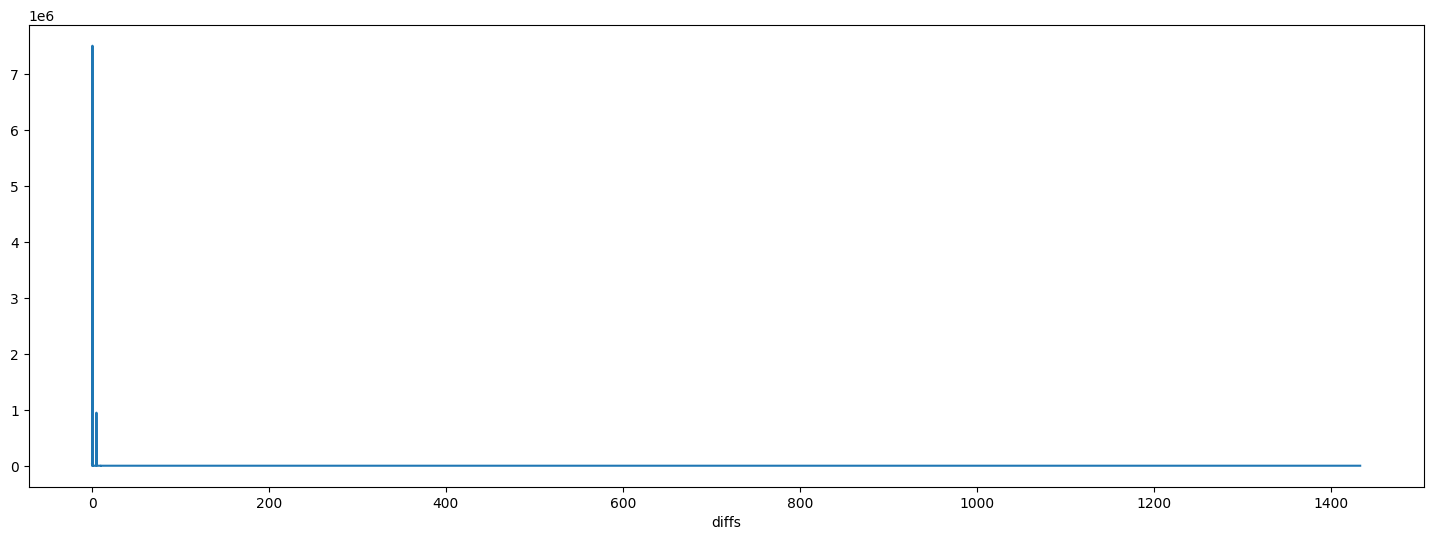

In [128]:
sorted_count = counts.sort_index()
# =x
sorted_count.plot(figsize=(18,6))

# Distribución espacial

,geometry,id
0,"POLYGON ((-70.75950 -33.41237, -70.76014 -33.4...",0
1,"POLYGON ((-70.73929 -33.38999, -70.73667 -33.3...",1
2,"POLYGON ((-70.54357 -33.54802, -70.54293 -33.5...",2
3,"POLYGON ((-70.54357 -33.54802, -70.54519 -33.5...",3
4,"POLYGON ((-70.78731 -33.56483, -70.79797 -33.5...",4
...,...,...
799,"POLYGON ((-70.75398 -33.36184, -70.74889 -33.3...",799
800,"POLYGON ((-70.74889 -33.36107, -70.74621 -33.3...",800
801,"POLYGON ((-70.74621 -33.36028, -70.74965 -33.3...",801
802,"POLYGON ((-70.73742 -33.35790, -70.73619 -33.3...",802


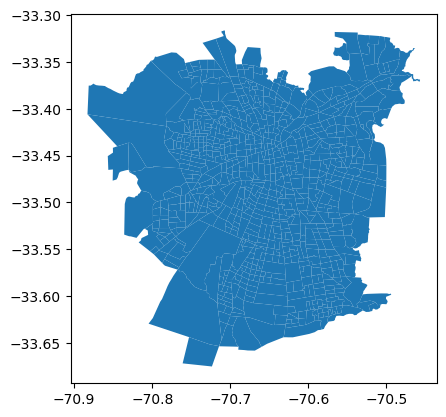

In [3]:
zones = gpd.read_file(RAW_DATA / 'Zonas777/Shape/Zonas777_V07_04_2014.shp')
zones.crs='EPSG:9152'
zones.plot()
zones['id'] = range(len(zones))
zones

In [4]:
puntos = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1, meta={'geometry': 'object'}).compute()

In [5]:
gdf_puntos = gpd.GeoDataFrame(geometry=puntos, crs='EPSG:9152')

In [6]:
# Realizar el spatial join
gdf_joined = gpd.sjoin(gdf_puntos, zones, how='inner', op='within')

# Contar la cantidad de puntos en cada zona
count_per_zone = gdf_joined.groupby('id').size().reset_index(name='count')

# Unir los conteos con el GeoDataFrame de zonas
zones = zones.merge(count_per_zone, on='id', how='left')
zones['count'] = zones['count'].fillna(0)  # Reemplazar NaN con 0 para zonas sin puntos

/home/flac/Documents/BusY/venv-notebooks/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
bins = [0, 25000, 50000, 75000, 100000, 200000, 300000]

agrupadas = pd.cut(zones['count'], bins=bins, include_lowest=True, right=False).value_counts()
agrupadas

count
[0, 25000)          742
[25000, 50000)       35
[50000, 75000)       10
[75000, 100000)       9
[100000, 200000)      6
[200000, 300000)      2
Name: count, dtype: int64

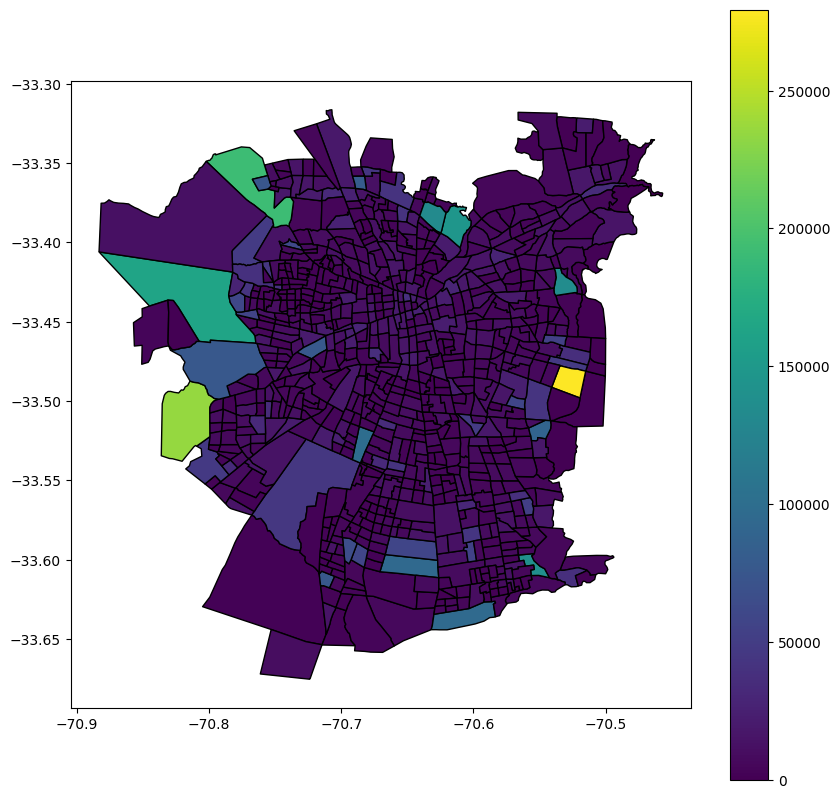

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear las zonas con colores basados en la cantidad de puntos
zones.plot(column='count', ax=ax, legend=True,
            # #    legend_kwds={#'label': "Cantidad de registros por Zona",
            #                 'orientation': "horizontal"},
               cmap='viridis', edgecolor='black')

# Añadir título y mostrar el mapa
# plt.title('Cantidad de registros por zona')
plt.show()

In [9]:
zones['density'] = zones['count'] / zones['geometry'].to_crs('EPSG:20048').area

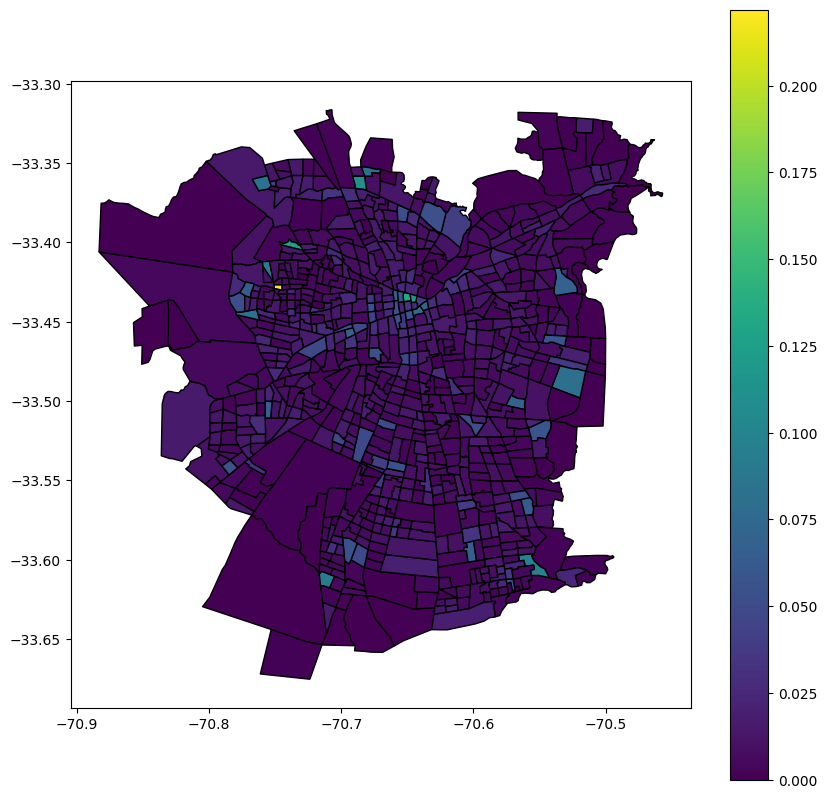

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear las zonas con colores basados en la cantidad de puntos
zones.plot(column='density', ax=ax, legend=True,
            #    legend_kwds={'label': "Densidad de registros por Zona (registros/m²)",
            #                 'orientation': "vertical"},
               cmap='viridis', edgecolor='black')

# Añadir título y mostrar el mapa
# plt.title('Densidad de registros por zona  (registros/m²)')
plt.show()

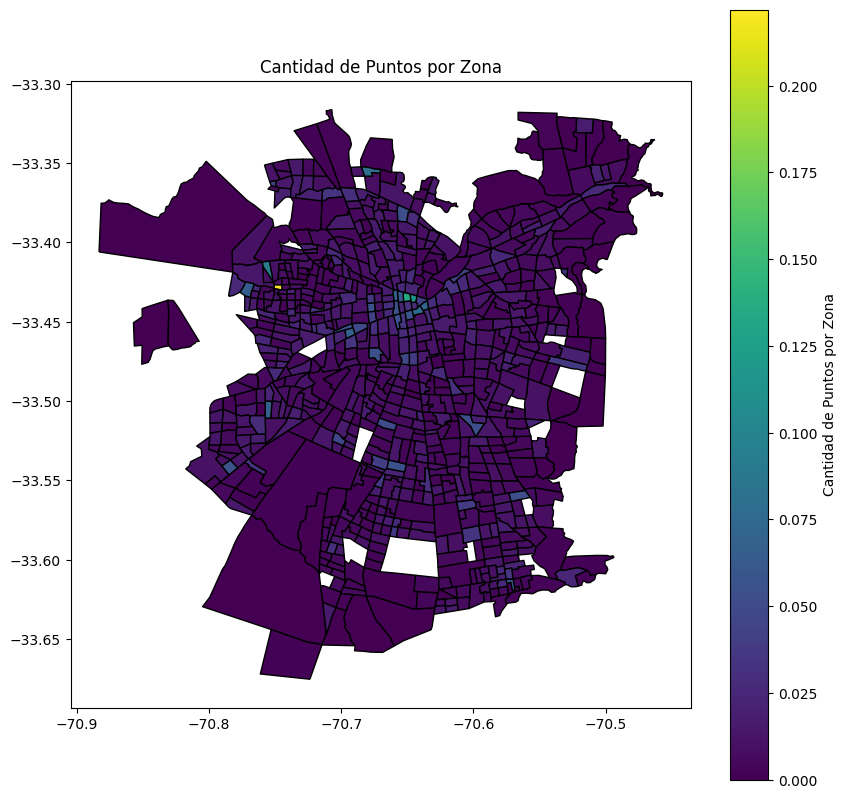

In [11]:
low_count = zones[zones['count'] <= 50000]
# Configurar el tamaño del mapa
fig, ax = plt.subplots(figsize=(10, 10))

low_count.plot(column='density', ax=ax, legend=True,
               legend_kwds={'label': "Cantidad de Puntos por Zona",
                            'orientation': "vertical"},
               cmap='viridis', edgecolor='black')

# low_count.plot(ax=ax)
# Añadir título y mostrar el mapa
plt.title('Cantidad de Puntos por Zona')
plt.show()